In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd
import os
import sys

sys.path.append(os.path.abspath('../'))

### 1.Introduction: In this notebook, I will clean,explore,analyze,visualize and finally build a Logistic regression model that can predict the booking status(cancel or not) by extracting and using the most appropriate features from the data


In [2]:
#Load the dataset and compress it
df = pd.read_csv("../data/Hotel Reservations.csv.zip", compression='zip') 
df.head()


,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


#### Let's copy dataframe and see the data types of each column


In [3]:
dff = df.copy()
dff.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

### 2.Exploratory Data Analysis


#### Let's look at the missing values


In [4]:
dff.isna().sum()


Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

#### No missing values. Next,let's see the duplicated values


In [5]:
dff.duplicated().sum()


np.int64(0)

#### This time, let's describe the whole dataframe


In [6]:
dff.describe()


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


#### Let's see the correlation of each sector of numeric columns


In [7]:
correlation=dff.corr(numeric_only=True)


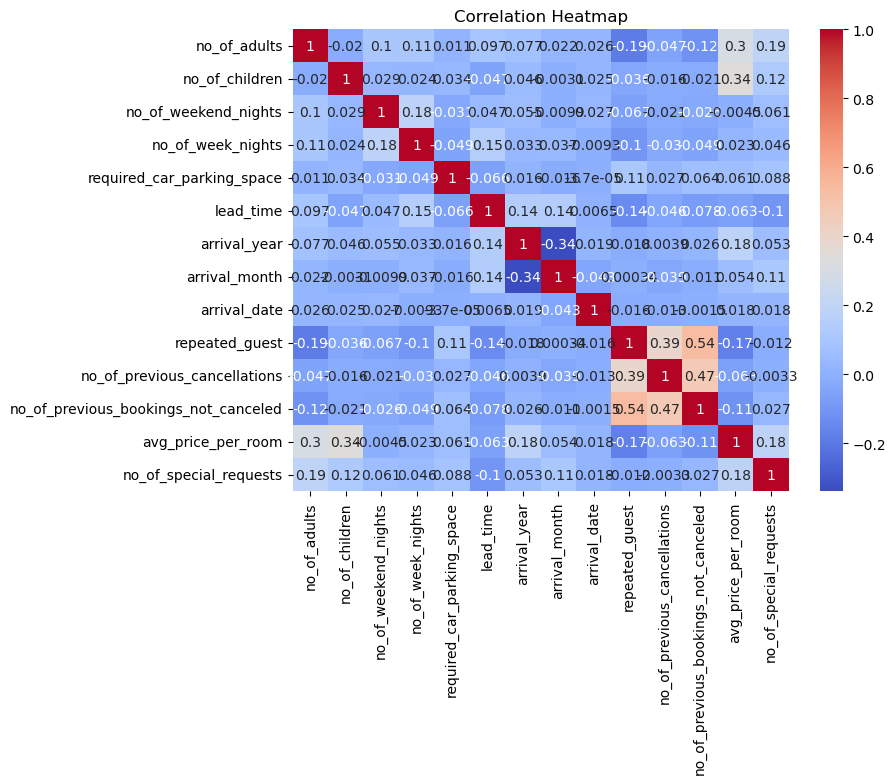

In [8]:
plt.figure(figsize=(8,6)) 
sns.heatmap(correlation, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap') 
plt.show()


__For all numeric, it seems difficult to see correlation of each factor. So let's dive into each one.__


#### let's see whether the lead time affects the cancelllation or not


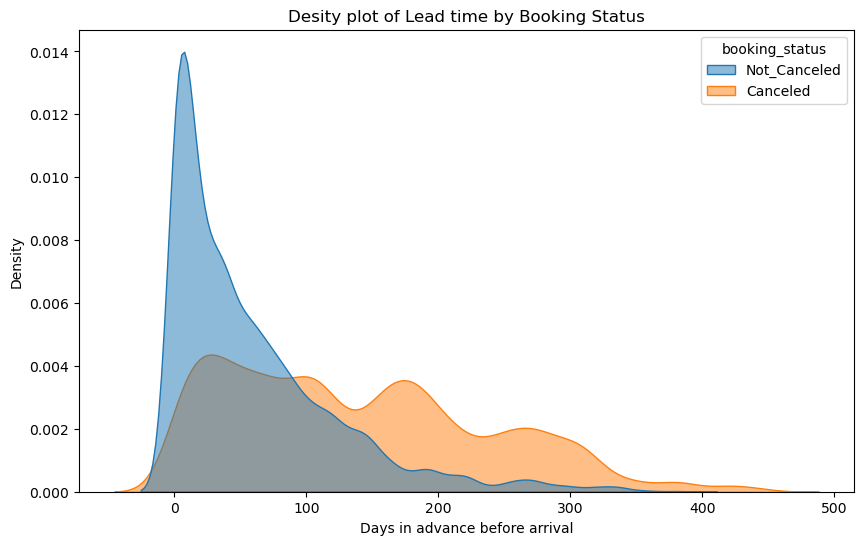

In [9]:
plt.figure(figsize=(10,6)) 
#I will use kdeplot to visualize the distribution of lead time based on booking status
sns.kdeplot(data=dff,x='lead_time',hue='booking_status',fill=True,alpha=0.5,common_norm=False)
plt.xlabel('Days in advance before arrival')
plt.ylabel('Density')
plt.title('Desity plot of Lead time by Booking Status')
plt.show()


__By Looking at the chart above,we can clearly see that lead time is affecting the cancellation rate. The longer the lead time, the more chances that the guests will cancel their booking.__


In [10]:
#let's bin the lead time for more detailed analysis
#we will call the function to categorize lead time in to bins
from  src.helper import categorize_lead_time
#we will craete a new column lead_time category using the function
dff['lead_time_category']= dff['lead_time'].apply(categorize_lead_time) 
#I made four categories based on the lead time days
dff['lead_time_category'].value_counts()


lead_time_category
4.Long Term(91+ days)      13049
3.Mid Term(31-90 days)     10815
2.Short Term(8-30 days)     6610
1.Last Minute(1-7 days)     5801
Name: count, dtype: int64

In [11]:
# this time, let's make a new column for cancelation status 
dff['is_canceled'] = dff['booking_status'].map({'Canceled': 1, 'Not_Canceled': 0}) 
dff.head()


,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,...,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,lead_time_category,is_canceled
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,...,2,Offline,0,0,0,65.00,0,Not_Canceled,4.Long Term(91+ days),0
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,...,6,Online,0,0,0,106.68,1,Not_Canceled,1.Last Minute(1-7 days),0
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,...,28,Online,0,0,0,60.00,0,Canceled,1.Last Minute(1-7 days),1
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,...,20,Online,0,0,0,100.00,0,Canceled,4.Long Term(91+ days),1
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,...,11,Online,0,0,0,94.50,0,Canceled,3.Mid Term(31-90 days),1


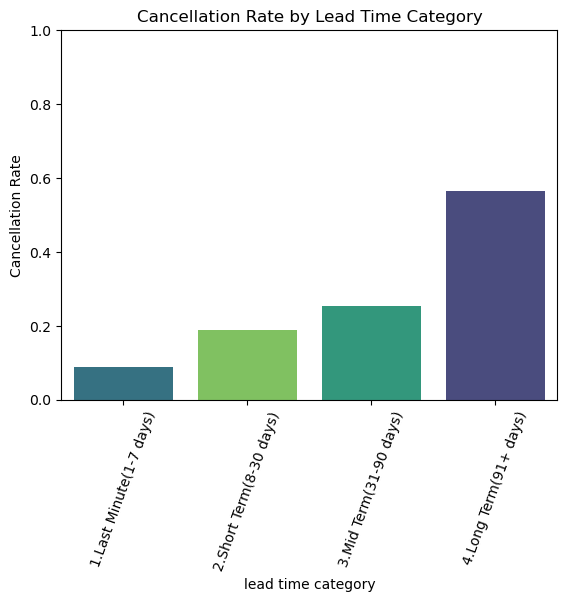

In [12]:
#let's visualize the cancellation rate by lead time category
# first let's make a ordered categorical type for lead time
order =['1.Last Minute(1-7 days)','2.Short Term(8-30 days)','3.Mid Term(31-90 days)','4.Long Term(91+ days)']
sns.barplot(data=dff, x='lead_time_category',y='is_canceled',hue='lead_time_category',order=order,errorbar=None,palette='viridis') 
plt.xlabel('lead time category') 
plt.ylabel('Cancellation Rate') 
plt.title('Cancellation Rate by Lead Time Category') 
plt.ylim(0,1) 
plt.xticks(rotation=70)
plt.show()


__We can more clearly see in the lead time bins that Long term reservations have more cancellation rate__
__The longer the lead time before arrival, the more likely chances that the guests will cancelled their reservations.__


#### I like to do some basic A/B testing to see more precisely whether lead time affects cancellation or not


In [13]:
#We need to make two groups to do A/B testing 
# First we will make short term group with is_canceled values
short_term_lead = dff[dff['lead_time_category']=='1.Last Minute(1-7 days)']['is_canceled']
long_term_lead = dff[dff['lead_time_category']=='4.Long Term(91+ days)']['is_canceled'] 
#let's print the mean cancellation rate for both groups
print(f'Short term lead time cancellation rate: {short_term_lead.mean():.2%}')
print(f'Long term lead time cancellation rate: {long_term_lead.mean():.2%}')


Short term lead time cancellation rate: 8.86%
Long term lead time cancellation rate: 56.63%


In [14]:
#The rate is significant,let's use scipy to do a t-test and p score 
from scipy import stats 
t_stat , p_value = stats.ttest_ind(short_term_lead,long_term_lead, equal_var=False) 
print(f"T statistic: {t_stat:.4f}, P-value: {p_value:.9f}") 
#we will assess the p score with 0.05 which is standard meter 
if p_value < 0.05:
    print('There is a significant difference between short term and long term lead time on cancellation rates.')
else:
    print('There is no significant difference between short term and long team lead time on cancellations')


T statistic: -83.4681, P-value: 0.000000000
There is a significant difference between short term and long term lead time on cancellation rates.


__Honest Reflection on Statistical Testing:
"Although I did an Independent T-test to compare cancellation rates, I acknowledge that since the target variable is binary (proportions), a Z-test for Proportions or a Chi-Square test would also be highly appropriate. The T-test results provided a P-value of $0.000$, confirming that the difference between short-term and long-term lead times is statistically significant and not due to random chance."__

#### Now, let's go deeper to each market sgement


In [15]:
#checking the unique values in market_segment_type
dff['market_segment_type'].unique()


array(['Offline', 'Online', 'Corporate', 'Aviation', 'Complementary'],
      dtype=object)

In [16]:
#Grouping by market segment types and booking status for plotting
market_segments = dff.groupby('market_segment_type')['booking_status'].value_counts().unstack()
market_segments


booking_status,Canceled,Not_Canceled
market_segment_type,,
Aviation,37.0,88.0
Complementary,NaN,391.0
Corporate,220.0,1797.0
Offline,3153.0,7375.0
Online,8475.0,14739.0


In [17]:
# we can see that complementary has no cancellations showing as NaN, so we will replace it with 0
market_segments = market_segments.fillna(0) 
#let's make it into percentages
market_segments_percent = market_segments.div(market_segments.sum(axis=1), axis=0) * 100
market_segments_percent


booking_status,Canceled,Not_Canceled
market_segment_type,,
Aviation,29.600000,70.400000
Complementary,0.000000,100.000000
Corporate,10.907288,89.092712
Offline,29.948708,70.051292
Online,36.508142,63.491858


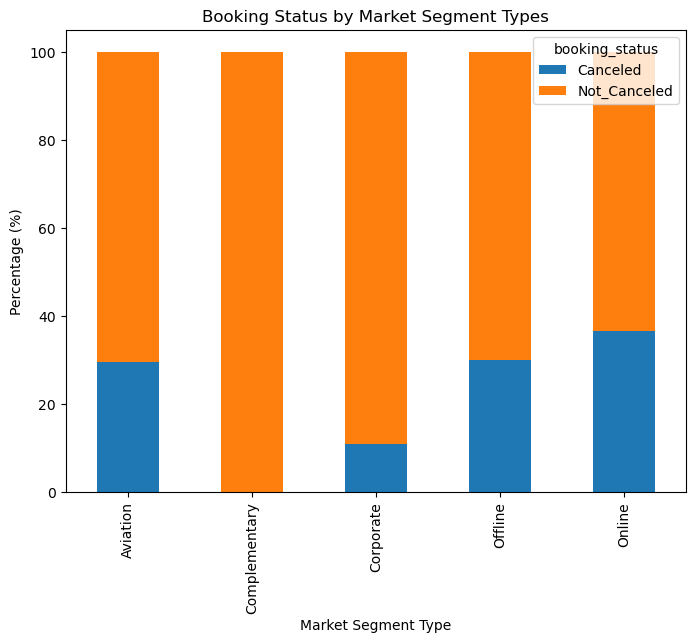

In [18]:
#lets plot the market segments 
market_segments_percent.plot(kind='bar',stacked=True, figsize=(8,6)) 
plt.title('Booking Status by Market Segment Types') 
plt.xlabel('Market Segment Type') 
plt.ylabel('Percentage (%)') 
plt.legend(title='booking_status')
plt.show()


***Based on the chart above, we can say that Online bookings have the most cancelled rate with around 37% followed by the Offline and Aviation bookings with around 30%.Complementary bookings have no cancellation rate due to its complementry rate and free complementary from hotel***


##### this time, let's see the average price per room of each market segment types


In [19]:
market_price = dff.groupby('market_segment_type')['avg_price_per_room'].mean().sort_values(ascending=False) 
market_price


market_segment_type
Online           112.256855
Aviation         100.704000
Offline           91.632679
Corporate         82.911740
Complementary      3.141765
Name: avg_price_per_room, dtype: float64

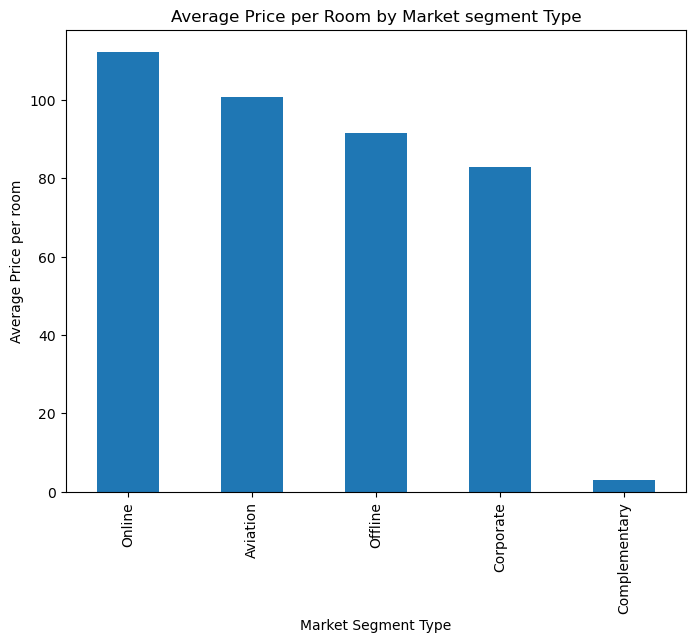

In [20]:
market_price.plot(kind='bar',figsize=(8,6))
plt.title('Average Price per Room by Market segment Type') 
plt.xlabel('Market Segment Type') 
plt.ylabel('Average Price per room') 
plt.show()


***By looking at the plot, we can conclude that reservations from Online have the highest average price per room and then reservations from aviation, offline , corporate and complementary are follwed respectively***


##### This time , let's see which market segment type make most revenue to our hotel by only looking at the not cancelled reservations


In [21]:
#first we need to filter the dataframe for not cancelled bookings
not_cancelled = dff[dff['booking_status'] == 'Not_Canceled']
not_cancelled.head()


,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,...,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,lead_time_category,is_canceled
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,...,2,Offline,0,0,0,65.00,0,Not_Canceled,4.Long Term(91+ days),0
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,...,6,Online,0,0,0,106.68,1,Not_Canceled,1.Last Minute(1-7 days),0
6,INN00007,2,0,1,3,Meal Plan 1,0,Room_Type 1,34,2017,...,15,Online,0,0,0,107.55,1,Not_Canceled,3.Mid Term(31-90 days),0
7,INN00008,2,0,1,3,Meal Plan 1,0,Room_Type 4,83,2018,...,26,Online,0,0,0,105.61,1,Not_Canceled,3.Mid Term(31-90 days),0
8,INN00009,3,0,0,4,Meal Plan 1,0,Room_Type 1,121,2018,...,6,Offline,0,0,0,96.90,1,Not_Canceled,4.Long Term(91+ days),0


In [22]:
#Now , we need to calculate the total revenue 
#We need to copy the dataframe to avoid SettingWithCopyWarning
not_cancelled = not_cancelled.copy()
# # First, we need to make a new column for total nights stayed   by adding week nights and weekend nights
not_cancelled['total_nights'] = not_cancelled['no_of_week_nights'] + not_cancelled['no_of_weekend_nights'] 
#Now we can calculate the total revenue by multiplying total nights by average price per room
not_cancelled['total_revenue'] = not_cancelled['total_nights'] * not_cancelled['avg_price_per_room'] 
not_cancelled.head()


,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,...,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,lead_time_category,is_canceled,total_nights,total_revenue
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,...,0,0,0,65.00,0,Not_Canceled,4.Long Term(91+ days),0,3,195.00
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,...,0,0,0,106.68,1,Not_Canceled,1.Last Minute(1-7 days),0,5,533.40
6,INN00007,2,0,1,3,Meal Plan 1,0,Room_Type 1,34,2017,...,0,0,0,107.55,1,Not_Canceled,3.Mid Term(31-90 days),0,4,430.20
7,INN00008,2,0,1,3,Meal Plan 1,0,Room_Type 4,83,2018,...,0,0,0,105.61,1,Not_Canceled,3.Mid Term(31-90 days),0,4,422.44
8,INN00009,3,0,0,4,Meal Plan 1,0,Room_Type 1,121,2018,...,0,0,0,96.90,1,Not_Canceled,4.Long Term(91+ days),0,4,387.60


In [23]:
#Lets group  the total revenue by market segment type 
revenue_by_market = not_cancelled.groupby('market_segment_type')['total_revenue'].sum().sort_values(ascending=False) 
revenue_by_market


market_segment_type
Online           4892158.59
Offline          1855433.18
Corporate         275493.91
Aviation           25240.00
Complementary       2778.99
Name: total_revenue, dtype: float64

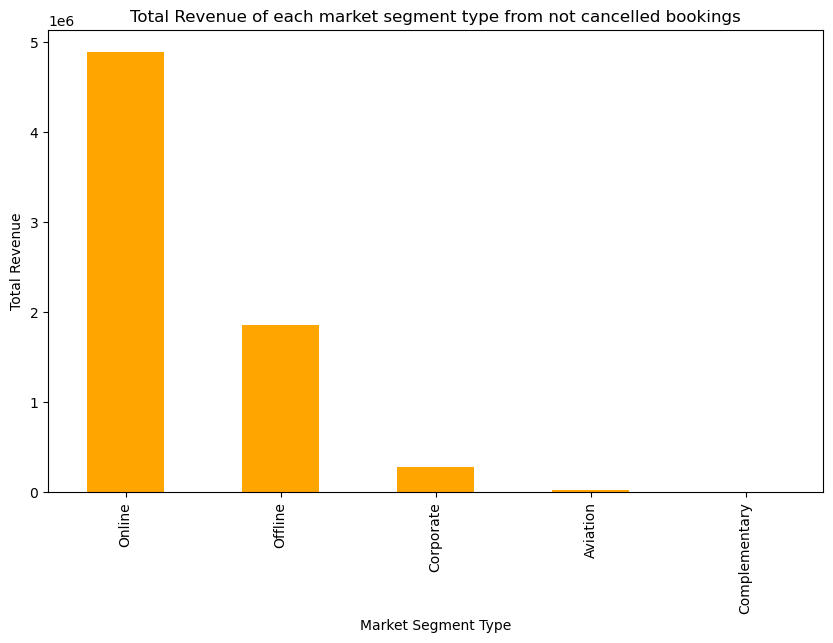

In [24]:
#Plotting the total revenue by market segment type 
revenue_by_market.plot(kind='bar', figsize=(10,6),color='orange') 
plt.title('Total Revenue of each market segment type from not cancelled bookings')
plt.xlabel('Market Segment Type')
plt.ylabel('Total Revenue') 
plt.show()


**Now, we can see clearly that onling reservations offer the highest revenue to the hotel although they have the most cancellation rate. We need to make cancellation plan  for the online bookings since the cancellation from online booking can have seriour effect on our hotel's total revenue.**


#### Some of the guests have previous cancelled reservations. So let's see what guests have cancelled previously


In [25]:
#let's see the values of previous cancellations
print(f'original data {dff["no_of_previous_cancellations"].value_counts()}')
#now let's look at the guests who had previous cancellations 
dff['previous_cancelled_guests'] = dff['no_of_previous_cancellations'] > 0 
dff['previous_cancelled_guests'].value_counts()


original data no_of_previous_cancellations
0     35937
1       198
2        46
3        43
11       25
5        11
4        10
13        4
6         1
Name: count, dtype: int64


previous_cancelled_guests
False    35937
True       338
Name: count, dtype: int64

### Let's visualize this


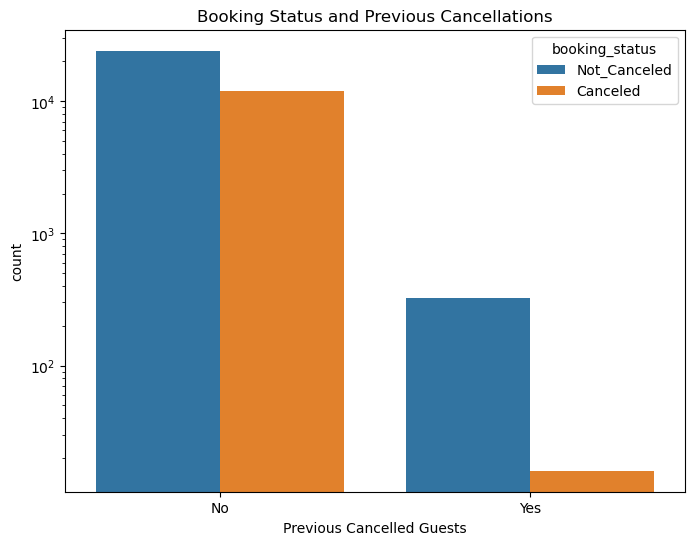

In [26]:
plt.figure(figsize=(8,6)) 
sns.countplot(data=dff, x='previous_cancelled_guests', hue='booking_status')
plt.xlabel('Previous Cancelled Guests')
#we have to use log scale here because of the data imbalance
plt.yscale('log')
plt.xticks([0,1],['No','Yes'])
plt.title('Booking Status and Previous Cancellations') 
plt.show()


__By looking at the chart above,there is not enough evidence that the previous cancelled guests are likely to cancel their reservations__


#### This time let's look at the revenue loss from each market segment 
#


In [27]:
#first we filter only cancelled bookings
cancelled = dff[dff['booking_status']=='Canceled'] 
#we will copy the dataframe to avoid SettingWithCopyWarning 
cancelled = cancelled.copy()
# first we need to make a new column for total nights stayed
cancelled['total_nights'] = cancelled['no_of_weekend_nights'] + cancelled['no_of_week_nights']
#And then we can make a total revenue column
cancelled['total_revenue'] = cancelled['total_nights'] * cancelled['avg_price_per_room'] 
#let's group by market segment type and sum the total revenue 
cancelled_revenue_by_market = cancelled.groupby('market_segment_type')['total_revenue'].sum().sort_values(ascending=False)
cancelled_revenue_by_market


market_segment_type
Online       3318253.94
Offline       894593.97
Corporate      58062.16
Aviation       25264.00
Name: total_revenue, dtype: float64

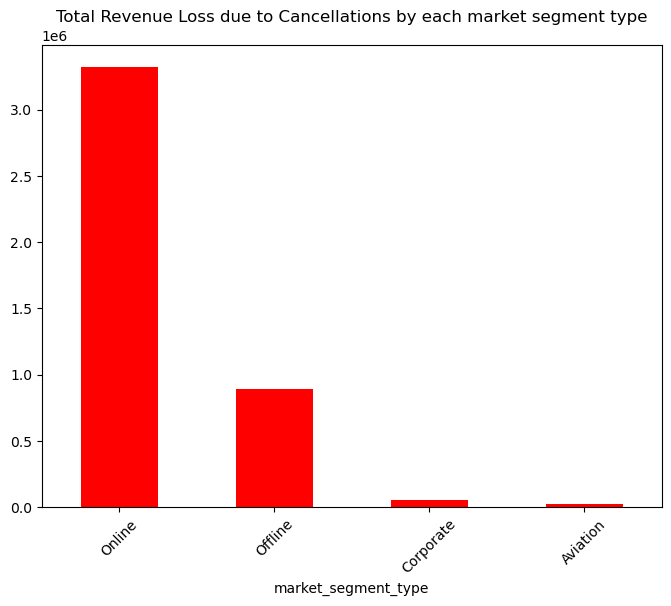

In [28]:
#now let's plot this cancelled revenue by market segment type 
cancelled_revenue_by_market.plot(kind='bar',figsize=(8,6),color='red') 
plt.title('Total Revenue Loss due to Cancellations by each market segment type') 
plt.xticks(rotation=45)
plt.show()


__We can see again that the total revenue loss by cancelled reservations from online segment has the highest loss to our hotel. We have to adjust cancellation policies on the online reservation.From my experience as a hotel receptionist, the most effective policy to prevent online booking cancellation is to introduce the non-refundable reservation type with discounted price meaning giving discounted less price commpared to refundable reservations.__


## 3.Feature Engineering


In [29]:
#we need to make a new column for total nights stayed
dff['total_nights'] = dff['no_of_weekend_nights'] + dff['no_of_week_nights']
#then we will select the relevant features for modeling in two lists 
#we will put the categorical features in one list and numeric features in another list
categorical_features = ['type_of_meal_plan',
                       'room_type_reserved',
                       'market_segment_type',
                       'previous_cancelled_guests',
                       'repeated_guest',
                       'required_car_parking_space',
                       'arrival_month']
numeric_features = ['no_of_previous_cancellations',
                    'no_of_previous_bookings_not_canceled',
                    'lead_time',
                    'no_of_special_requests',
                    'avg_price_per_room',
                    'total_nights']
#then we will combine them with the target variable in a new dataframe
data = dff[categorical_features + numeric_features + ['is_canceled']]


### 4. Training the model


In [30]:
#for modeling , we need to separate the features and target variable
X = data.drop('is_canceled', axis=1)
Y = data['is_canceled']


In [31]:
#we will call the booking predictor from hotelpipe and train the model
from src.hotelpipe import booking_predictor
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split , cross_val_score 
#split the data into training and testing sets train 80% test 20%
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)
model = booking_predictor(numeric_features, categorical_features) 
model.fit(X_train, Y_train) 
y_pred = model.predict(X_test) 
print(classification_report(Y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.89      0.86      4839
           1       0.74      0.63      0.68      2416

    accuracy                           0.80      7255
   macro avg       0.79      0.76      0.77      7255
weighted avg       0.80      0.80      0.80      7255



***Precision (74%): This indicates that when the model flags a booking as "Likely to Cancel," it is correct 74% of the time. This is high enough to be used for targeted outreach without high risk of bothering guests who plan to show up.***


***Recall (63%): This points out that the model successfully identifies 63 out of every 100 actual cancellations before they occur. In other words, we are capturing over half of our potential revenue loss early.***


***F1-Score (68%): This represents a solid balance between precision and recall. While the model is effective, there is still room for improvement, particularly in capturing the remaining 37% of cancellations that the model currently misses (False Negatives).***


In [32]:
# for more robust evaluation,we will use cross validation
crossVscore= cross_val_score(model, X, Y, cv=5, scoring='accuracy') 
print(f'Cross Validation Scores: {crossVscore}')
print(f'Mean Cross Validation Score: {crossVscore.mean():.4f}')


Cross Validation Scores: [0.82191592 0.8019297  0.79586492 0.79986216 0.79903515]
Mean Cross Validation Score: 0.8037


__for more robust and consistency of model's performance not just due to the luck in train_test_split, I performed 5-fold cross validation__


__As you can see, the model performs well and consistencently across different validation folds.
# This indicates that our feature selection and preprocessing steps were effective in capturing the patterns associated with booking cancellations. 
# Further tuning and experimentation with different algorithms could potentially enhance the model's performance even more.__
